In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib
import ast
from tabulate import tabulate
from kneed import KneeLocator


StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 6, Finished, Available, Finished)

In [3]:
import pandas as pd
# Load data into pandas DataFrame from "/lakehouse/default/Files/raw/Seg_Data01.csv"
data = pd.read_csv("/lakehouse/default/Files/raw/Seg_Data01.csv")
data.shape


StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 7, Finished, Available, Finished)

(599130, 66)

In [4]:
#Columns that will be added back to out
retail_cols = ['msisdn', 'activation_date', 'cell_id', 'Date_of_birth', 'Value_band','tenure']
df_retail = data[retail_cols].copy()

# Drop columns with excessive missing values
df_cleaned = data.drop(columns=['momo_bundle', 'int_inc_dur', 'total_freebiz','tenure','age','bonus_duration'], errors='ignore')

# Convert activation_date to datetime and extract tenure in years
df_cleaned['activation_date'] = pd.to_datetime(df_cleaned['activation_date'], errors='coerce')
df_cleaned['tenure_years'] = (pd.to_datetime('today') - df_cleaned['activation_date']).dt.days / 365

# Convert Date_of_birth to Age
df_cleaned['Date_of_birth'] = pd.to_datetime(df_cleaned['Date_of_birth'], errors='coerce')
df_cleaned['age'] = (pd.to_datetime('today') - df_cleaned['Date_of_birth']).dt.days / 365

# Convert categorical 'service_class' to numeric encoding
df_cleaned['service_class'] = df_cleaned['service_class'].astype('category').cat.codes

# Drop non-numeric and identifier columns
cols_to_drop = ['msisdn', 'activation_date', 'cell_id', 'Date_of_birth', 'Value_band']
df_cleaned = df_cleaned.drop(columns=cols_to_drop, errors='ignore')

# Fill missing values with median
df_cleaned = df_cleaned.fillna(df_cleaned.median())

# Feature Engineering
df_cleaned['Revenue_per_Minute'] = df_cleaned['voice_spent'] / (df_cleaned['out_call_duration_billed'] + 1)
df_cleaned['Recharge_Frequency'] = df_cleaned['total_recharge_amount'] / (df_cleaned['total_recharge_count'] + 1)



StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 8, Finished, Available, Finished)

In [5]:
# Standardize numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)



StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 9, Finished, Available, Finished)

In [6]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)



StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 10, Finished, Available, Finished)

In [7]:

# Determine optimal number of clusters using the Elbow Method
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)



StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 11, Finished, Available, Finished)

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 12, Finished, Available, Finished)

Optimal number of clusters (k): 5


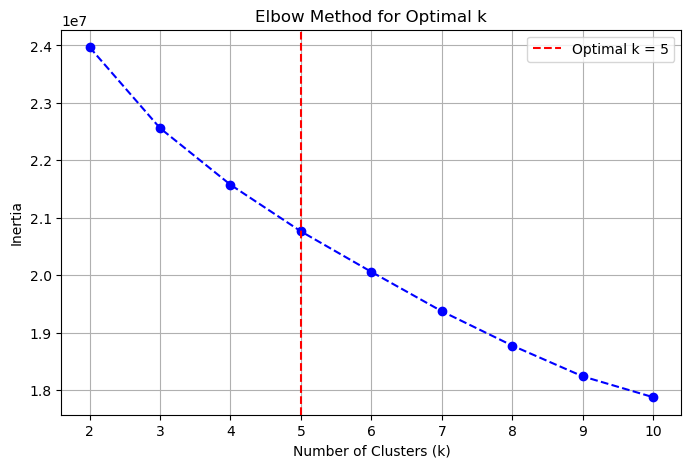

In [8]:
# Use KneeLocator to find the elbow (optimal k)
kneedle = KneeLocator(list(K_range), inertia, curve="convex", direction="decreasing")
optimal_k = kneedle.knee

print(f"Optimal number of clusters (k): {optimal_k}")

# Elbow Plot with dynamic vertical line
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
if optimal_k:
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.legend()
plt.savefig("/lakehouse/default/Files/logs/elbow_plot.png")
plt.show()

In [9]:
# Set optimal number of clusters
#Use dynamic optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cleaned["Cluster"] = kmeans.fit_predict(df_pca)

#kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
#df_cleaned["Cluster"] = kmeans.fit_predict(df_pca)



StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 13, Finished, Available, Finished)

In [10]:
# Identify key features in each cluster
def identify_top_features(cluster_centers, feature_names):
    return pd.DataFrame(cluster_centers, columns=feature_names)

cluster_centers = pca.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = identify_top_features(cluster_centers, df_cleaned.drop(columns=['Cluster']).columns)



StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 14, Finished, Available, Finished)

In [11]:
# Define a mapping of dominant feature sets to meaningful labels
# Read from the .txt file
with open("/lakehouse/default/Files/model_dir/feature_label_mapping.txt", 'r') as file:
    content = file.read()

# Convert the string content into a Python dictionary
feature_label_mapping = ast.literal_eval(content)


StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 15, Finished, Available, Finished)

In [12]:
def get_top_features(cluster_centers_df, n=3):
    """Identify the top `n` dominant features for each cluster."""
    top_features = {}
    for i, row in cluster_centers_df.iterrows():
        top_3 = row.abs().nlargest(n).index.tolist()
        top_features[i] = tuple(top_3)
    return top_features

def assign_dynamic_labels(top_features):
    """Assign meaningful labels to clusters based on dominant features."""
    cluster_labels = {}
    for cluster, features in top_features.items():
        label = feature_label_mapping.get(features, "Other")
        cluster_labels[cluster] = label
    return cluster_labels


StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 16, Finished, Available, Finished)

In [13]:
# Identify dominant features per cluster
top_features = get_top_features(cluster_centers_df)
top_features

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 17, Finished, Available, Finished)

{0: ('out_call_duration', 'out_call_duration_billed', 'onnet_call_duration'),
 1: ('subscription_amt', 'total_recharge_amount', 'Total_Revenue'),
 2: ('peak_inc_dur', 'onnet_inc_dur', 'inc_call_duration'),
 3: ('gpprs_traffic_up_down', 'total_spent', 'recharge_momo_count'),
 4: ('onnet_sms_count', 'total_sms_count', 'out_unbilled_sms_count')}

In [14]:
def get_top_features_and_rank(cluster_centers_df, n=3):
    """
    Identify the top `n` dominant features for each cluster and return
    a list of dictionaries with: Cluster_Label, KPI_Rank, KPI_Name, KPI_Value
    """
    top_features_list = []
    for i, row in cluster_centers_df.iterrows():
        top_kpis = row.abs().nlargest(n)
        for rank, (feature, value) in enumerate(top_kpis.items(), 1):
            top_features_list.append({
                "Cluster_Label": f"Segment_{i}",
                "KPI_Rank": rank,
                "KPI_Name": feature,
                "KPI_Value": round(row[feature], 2)  # Use actual value (not abs)
            })
    return top_features_list

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 18, Finished, Available, Finished)

In [15]:
top_kpi_data = get_top_features_and_rank(cluster_centers_df)
#top_kpi_data
# Convert to DataFrame for export or visualization
top_kpi_df = pd.DataFrame(top_kpi_data)
# Export to CSV
top_kpi_df.to_csv("/lakehouse/default/Files/output_data/PBI_Top_KPIs_Per_Segment.csv", index=False)

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 19, Finished, Available, Finished)

In [16]:
# Assign dynamic labels
cluster_labels = assign_dynamic_labels(top_features)

df_cleaned['Segment_Label'] = df_cleaned['Cluster'].map(cluster_labels)

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 20, Finished, Available, Finished)

In [17]:
cluster_labels

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 21, Finished, Available, Finished)

{0: 'Call Heavy User',
 1: 'Subscription Heavy',
 2: 'Peak-Time Receiver',
 3: 'Spend-Driven Data User',
 4: 'Unbilled Texter'}

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 22, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c17eff9d-46e2-45a1-8066-735ce42b1d8c)

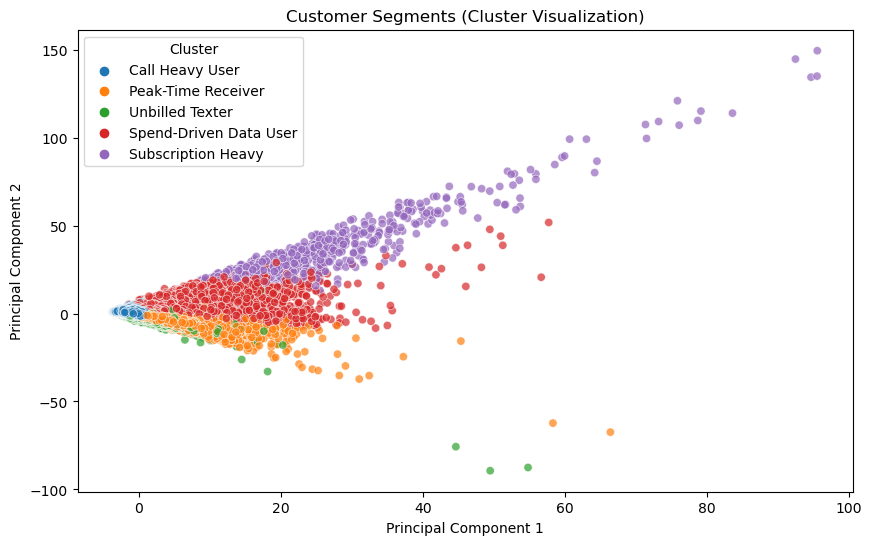

In [18]:
#Print significant top 3 features within cluster
# Join and prepare rows
rows = []
for cluster_id in top_features:
    label = cluster_labels.get(cluster_id, "Unknown")
    features = ', '.join(top_features[cluster_id])
    rows.append([cluster_id, label, features])


label_map_df = pd.DataFrame([
    {"Cluster": cid, "Mapped Name": cluster_labels[cid], "Most significant Features": ', '.join(top_features[cid])}
    for cid in top_features
])

display(label_map_df)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_cleaned['Segment_Label'], palette='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segments (Cluster Visualization)')
plt.legend(title='Cluster')
plt.show()



In [19]:
# Save the model (KMeans and Scaler)
joblib.dump(kmeans, '/lakehouse/default/Files/model_dir/kmeans_model.pkl')
joblib.dump(scaler, '/lakehouse/default/Files/model_dir/scaler.pkl')

# save pca
joblib.dump(pca, '/lakehouse/default/Files/model_dir/pca.pkl')

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 23, Finished, Available, Finished)

['/lakehouse/default/Files/model_dir/pca.pkl']

In [20]:
df_output = pd.concat([df_retail.reset_index(drop=True), df_cleaned.reset_index(drop=True)], axis=1)

# Save the final dataframe with clusters and labels
df_output.to_csv("/lakehouse/default/Files/output_data/segmentation_output.csv", index=False)

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 24, Finished, Available, Finished)

In [21]:
df_output.head(3)

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 25, Finished, Available, Finished)

,msisdn,activation_date,cell_id,Date_of_birth,Value_band,tenure,service_class,total_spent,voice_spent,data_spent,...,Total_Revenue,momo_fees,vas_spent,data_bundled_purchase,tenure_years,age,Revenue_per_Minute,Recharge_Frequency,Cluster,Segment_Label
0,E61B816EAAE802B3,28-Dec-2021,62001-433-8175,1970-04-05,LV,39,8,0.760800,0.160800,0.0,...,16.760800,3.8,0.6,20.18,3.276712,55.043836,0.000708,2.500000,0,Call Heavy User
1,99DC0DB55446CFF0,27-Jul-2022,62001-60101-42014,2001-09-08,LV,32,1,0.887466,0.887466,0.0,...,10.487466,0.5,0.0,3.00,2.698630,23.594521,0.002665,3.333333,0,Call Heavy User
2,42CE27E7DFF7D8FA,12-Apr-2018,62001-60133-31585,1993-03-30,LV,84,6,0.000000,0.000000,0.0,...,17.350000,8.7,0.0,20.18,6.991781,32.043836,0.000000,0.800000,0,Call Heavy User


In [22]:
# Save the PCA-transformed data used for plotting
pca_df = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
pca_df['Cluster'] = df_cleaned['Cluster']
pca_df['Segment_Label'] = df_cleaned['Segment_Label']
pca_df.to_csv("/lakehouse/default/Files/output_data/cluster_plot_data.csv", index=False)

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 26, Finished, Available, Finished)

In [23]:
# Save the cluster label mapping
label_map_df = pd.DataFrame([
    {"Cluster": cid, "Mapped Name": cluster_labels[cid], "Most significant Features": ', '.join(top_features[cid])}
    for cid in top_features
])
label_map_df.to_csv("/lakehouse/default/Files/output_data/cluster_feature_mapping.csv", index=False)

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 27, Finished, Available, Finished)

In [24]:
label_map_df.head()

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 28, Finished, Available, Finished)

,Cluster,Mapped Name,Most significant Features
0,0,Call Heavy User,"out_call_duration, out_call_duration_billed, o..."
1,1,Subscription Heavy,"subscription_amt, total_recharge_amount, Total..."
2,2,Peak-Time Receiver,"peak_inc_dur, onnet_inc_dur, inc_call_duration"
3,3,Spend-Driven Data User,"gpprs_traffic_up_down, total_spent, recharge_m..."
4,4,Unbilled Texter,"onnet_sms_count, total_sms_count, out_unbilled..."


In [25]:
# Print using tabulate if available
try:
    print(tabulate(rows, headers=["Cluster", "Mapped Name", "Most significant Features"], tablefmt="github"))
except ImportError:
    # Fallback simple table
    print(f"{'Cluster':<8}{'Mapped Name':<30}Features")
    print("-" * 80)
    for row in rows:
        print(f"{row[0]:<8}{row[1]:<30}{row[2]}")

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 29, Finished, Available, Finished)

|   Cluster | Mapped Name            | Most significant Features                                        |
|-----------|------------------------|------------------------------------------------------------------|
|         0 | Call Heavy User        | out_call_duration, out_call_duration_billed, onnet_call_duration |
|         1 | Subscription Heavy     | subscription_amt, total_recharge_amount, Total_Revenue           |
|         2 | Peak-Time Receiver     | peak_inc_dur, onnet_inc_dur, inc_call_duration                   |
|         3 | Spend-Driven Data User | gpprs_traffic_up_down, total_spent, recharge_momo_count          |
|         4 | Unbilled Texter        | onnet_sms_count, total_sms_count, out_unbilled_sms_count         |


In [26]:
#Validations
target_msisdns = ['E61B816EAAE802B3', '99DC0DB55446CFF0', '42CE27E7DFF7D8FA']
filtered_df = df_output[df_output['msisdn'].isin(target_msisdns)]
filtered_df.shape

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 30, Finished, Available, Finished)

(3, 68)

In [27]:
#Validations
target_msisdns = ['E61B816EAAE802B3', '99DC0DB55446CFF0', '42CE27E7DFF7D8FA']
filtered_df = data[data['msisdn'].isin(target_msisdns)]
filtered_df

StatementMeta(, abe38d1a-2c6f-4189-a365-e94e39ca3d14, 31, Finished, Available, Finished)

,msisdn,service_class,activation_date,tenure,cell_id,total_spent,total_freebiz,voice_spent,data_spent,sms_spent,...,recharge_momo_count,recharge_momo_amount,subscription_amt,Date_of_birth,Value_band,Total_Revenue,momo_fees,momo_bundle,vas_spent,data_bundled_purchase
0,E61B816EAAE802B3,XcnGPRS,28-Dec-2021,39,62001-433-8175,0.760800,14.784053,0.160800,0.0,0.0,...,1.0,5.0,12.20,1970-04-05,LV,16.760800,3.8,NaN,0.6,NaN
1,99DC0DB55446CFF0,FA1_Extra,27-Jul-2022,32,62001-60101-42014,0.887466,28.081192,0.887466,0.0,0.0,...,2.0,10.0,9.10,2001-09-08,LV,10.487466,0.5,NaN,0.0,3.0
2,42CE27E7DFF7D8FA,MTN_Zone,12-Apr-2018,84,62001-60133-31585,0.000000,14.176236,0.000000,0.0,0.0,...,4.0,4.0,8.65,1993-03-30,LV,17.350000,8.7,NaN,0.0,NaN
